In [ ]:
import numpy as np
from fairlearn.datasets import fetch_acs_income
from sklearn import preprocessing
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import equalized_odds_difference
import numpy as np
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource


import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
# load dataset
import pandas as pd
from fairlearn.reductions import EqualizedOdds
import warnings
warnings.filterwarnings('ignore')

from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import Fairlearn_Model, Sklearn_Model


# load dataset

In [186]:
data = fetch_acs_income(as_frame=False,states=["CA"])
sex = data.data[:,data['feature_names'].index('SEX')]
X = data.data
y_true = (data.target > 50000) * 1
X = preprocessing.normalize(X, norm='l2')

In [187]:
X.shape, y_true.shape

((195665, 10), (195665,))

# standard model

In [188]:

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
print(gm.overall)
print(gm.by_group)
print(equalized_odds_difference(y_true,
                                y_pred,
                                sensitive_features=sex))

0.7455702348401605
sensitive_feature_0
1.0    0.732420
2.0    0.760281
Name: accuracy_score, dtype: float64
0.029908267724111592


# fair models


In [189]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import equalized_odds_difference

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
sr_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.7544016558914471
sensitive_feature_0
1.0    0.744606
2.0    0.765359
Name: accuracy_score, dtype: float64


In [190]:
print(equalized_odds_difference(y_true,
                                y_pred_mitigated,
                                sensitive_features=sex))


0.0006599766260567685


# Attack models

In [206]:
# for the population metric
seed = 1234
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
# for training the target and reference models
num_train_points = 2000
num_test_points = 2000
num_fair_train_points = 10000
num_population_points = 30000

train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
population_index = np.random.choice(X.shape[0], num_population_points, replace=False)

In [207]:
input_shape= X.shape[-1]
num_classes= 1

In [208]:
# create the target model's dataset
g_train  = (y_true[train_index])+ (sex[train_index])*2
g_test  = (y_true[test_index])+ (sex[test_index])*2
g_pop_train = (y_true[population_index])+ (sex[population_index])*2

In [209]:
# create the target model's dataset
train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y', default_group='g'
)

# create the reference dataset
population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='x', default_output='y', default_group='g'
)

In [210]:
def log(y, pre):
    e = 0.0000001
    pre = np.clip(pre, e, 1 - e)
    return - y * np.log(pre) - (1 - y) * np.log(1 - pre)

model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=8)
model.fit(X[train_index], y_true[train_index])
target_model = Sklearn_Model(model_obj=model, loss_fn=log)
print(model)
y_pred_test= model.predict(X[test_index])
sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sex[test_index])
y_pred_train= model.predict(X[train_index])
sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sex[train_index])
print(sr_test.overall, sr_test.by_group)
print(sr_train.overall, sr_train.by_group)
print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sex[test_index]))

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10)
0.7405 sensitive_feature_0
1.0    0.746860
2.0    0.733679
Name: accuracy_score, dtype: float64
0.806 sensitive_feature_0
1.0    0.810732
2.0    0.801026
Name: accuracy_score, dtype: float64
0.22076978939724035


In [211]:
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=8)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X[train_index], y_true[train_index], sensitive_features=sex[train_index])
fair_target_model = Fairlearn_Model(model_obj=mitigator, loss_fn=log)
print(mitigator)
y_pred_test= mitigator.predict(X[test_index])
sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sex[test_index])
y_pred_train= mitigator.predict(X[train_index])
sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sex[train_index])
print(sr_test.overall, sr_test.by_group)
print(sr_train.overall, sr_train.by_group)
print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sex[test_index]))

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x7f0468ccd370>,
                      estimator=DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=10),
                      nu=0.004422134963885591)
0.742 sensitive_feature_0
1.0    0.743961
2.0    0.739896
Name: accuracy_score, dtype: float64
0.8135 sensitive_feature_0
1.0    0.815610
2.0    0.811282
Name: accuracy_score, dtype: float64
0.05319535221496008


In [212]:
un_target_info_source = InformationSource(
    models=[target_model], 
    datasets=[target_dataset]
)

un_reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

fair_target_info_source = InformationSource(
    models=[fair_target_model], 
    datasets=[target_dataset]
)

fair_reference_info_source = InformationSource(
    models=[fair_target_model],
    datasets=[reference_dataset]
)

In [221]:
from privacy_meter import audit_report
from privacy_meter.audit_report import *


un_audit_obj = Audit(
    metrics=MetricEnum.GROUPPOPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=un_target_info_source,
    reference_info_sources=un_reference_info_source,
    logs_directory_names='un_log'
)
un_audit_obj.prepare()

In [222]:
fair_audit_obj = Audit(
    metrics=MetricEnum.GROUPPOPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=fair_target_info_source,
    reference_info_sources=fair_reference_info_source,
    logs_directory_names='fair_log'
)
fair_audit_obj.prepare()

In [223]:
# un_audit_results = un_audit_obj.run()[0]
# fair_audit_results = fair_audit_obj.run()[0]

In [224]:
# tpr = un_audit_results[0].tp/(un_audit_results[0].tp+un_audit_results[0].fn)
# fpr = un_audit_results[0].fp/(un_audit_results[0].fp+un_audit_results[0].tn)
# roc = np.trapz(tpr, fpr)
# fair_tpr = fair_audit_results[0].tp/(fair_audit_results[0].tp+fair_audit_results[0].fn)
# fair_fpr = fair_audit_results[0].fp/(fair_audit_results[0].fp+fair_audit_results[0].tn)
# fair_roc = np.trapz(fair_tpr, fair_fpr)
# plt.title('Overall ROC')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
# plt.plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}')
# plt.plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}')
# plt.legend()
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

In [225]:
# show the results in each group 
un_train_signal = un_audit_obj.metric_objects[0].member_signals
un_test_signal = un_audit_obj.metric_objects[0].non_member_signals
un_pop_signal = un_audit_obj.metric_objects[0].reference_signals

fair_train_signal = fair_audit_obj.metric_objects[0].member_signals
fair_test_signal = fair_audit_obj.metric_objects[0].non_member_signals
fair_pop_signal = fair_audit_obj.metric_objects[0].reference_signals

In [226]:
import scipy
def compute_p_value( target_value, observed_distribution):
    return scipy.stats.percentileofscore(observed_distribution, target_value)/100

p_results = {}
p_fair_results = {}

for g in np.unique(g_train):
    un_pop = un_pop_signal[g_pop_train==g]
    p_train = compute_p_value(un_train_signal[g_train==g], un_pop)
    p_test = compute_p_value(un_test_signal[g_test==g], un_pop)
    p_results[g] = {}
    p_results[g]['p'] = np.concatenate([p_train, p_test])
    p_results[g]['mem'] = np.concatenate([np.ones(len(p_train)), np.zeros(len(p_test))])
    
    
    fair_pop  = fair_pop_signal[g_pop_train==g]
    p_fair_train = compute_p_value(fair_train_signal[g_train==g], fair_pop)
    p_fair_test = compute_p_value(fair_test_signal[g_test==g], fair_pop)
    p_fair_results[g] = {}
    p_fair_results[g]['p'] = np.concatenate([p_fair_train, p_fair_test])
    p_fair_results[g]['mem'] = np.concatenate([np.ones(len(p_fair_train)), np.zeros(len(p_fair_test))])
    

In [227]:
g_train.shape

(2000,)

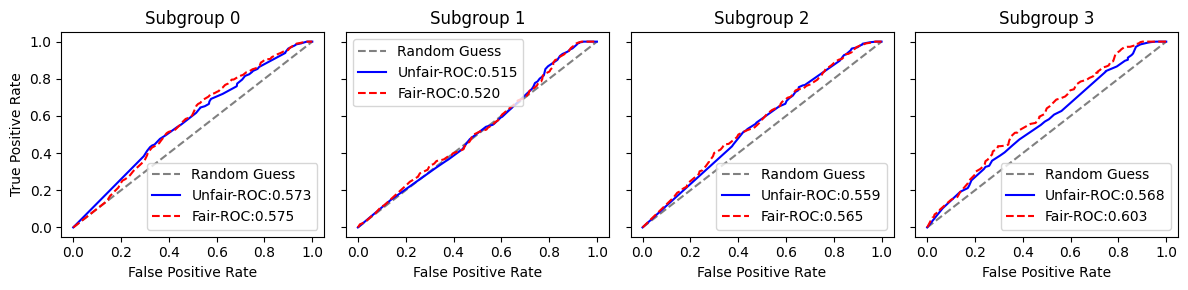

In [228]:
figs, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)

# group = np.unique(g_train)
for idx, group in enumerate(np.unique(g_train)):
    tpr = [np.mean(p_results[group]['p'][p_results[group]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fpr = [np.mean(p_results[group]['p'][p_results[group]['mem']==0]<i) for i in np.linspace(0,1,100)]

    fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem']==0]<i) for i in np.linspace(0,1,100)]

    roc = np.trapz(tpr, fpr)
    fair_roc = np.trapz(fair_tpr, fair_fpr)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
    axes[idx].plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}', color='blue')
    axes[idx].plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}', ls='--', color='red')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_title(f'Subgroup {idx}')
    axes[idx].legend()
axes[0].set_ylabel('True Positive Rate')
plt.tight_layout()